# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_15158/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

# Mean square error Loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)
    
# Binary cross entropy Loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted - (1 - actual) / (1 - predicted)) / len(actual)))
    
# Categorical cross entropy Loss

class CatCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - (np.sum(actual * np.log(predicted + 10**(-5)) / len(actual)))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - ((actual / (predicted + 10**(-5))) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(4)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x: Tensor) -> Tensor:
    return np.maximum(0,x)

def relu_prime(x: Tensor) -> Tensor:
    return np.where(x <= 0, 0, 1)

def softmax(x: Tensor) -> Tensor:
    exp = np.exp(x)
    sum = np.sum(exp, axis=1)
    result: Sequence = []

    for i in range (0, len(sum)):
        result.append(np.round(exp[i] / sum[i], 5))
        
    return np.array(result)

def softmax_prime(x: Tensor) -> Tensor:
    S = softmax(x)
    diag : Sequence = []
    matrix: Sequence = []
    for i in S:
        diag.append(np.diag(i))
        M = np.tile(i.reshape(i.shape[0],1),i.shape[0])
        matrix.append(M * np.transpose(M)) 
    
    D = np.array(diag)
    S_matrix = np.array(matrix)

    S_prime = D - S_matrix

    result: Sequence = []

    for i in range (0, len(S_prime)):
        result.append(S_prime[i] @ x[i])
    
    return np.round(np.array(result), 5)

# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
x = Tensor(shape=(2,3), dtype=int, buffer=np.array([[1, 0, 3], [4, 6, 9]]))
print(x)
y = softmax(x)
print(y)

z = softmax_prime(x)
print(z)

[[1 0 3]
 [4 6 9]]
[[0.1142  0.04201 0.84379]
 [0.00638 0.04712 0.9465 ]]
[[-0.18792 -0.11114  0.29906]
 [-0.03079 -0.1332   0.16399]]


### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])


class DataIterator:
    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        raise NotImplementedError

        
class BatchIterator(DataIterator):
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        num_epochs: int = 5000,
        UseBatch: bool = False) -> None:

    Loss_list : Sequence = []
    Acc_list : Sequence = []
        
    if UseBatch == True:

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            Predicted_list: Sequence = [] 
            for batch in iterator(inputs, targets):

                Batch_loss : Sequence = []
                Batch_grad : Sequence = []
                #Batch_acc : Sequence = []

                predicted = net.forward(batch[0])
                for i in predicted:
                    Predicted_list.append(i)
                Batch_loss.append(loss.loss(predicted, batch[1]))
                grad = loss.grad(predicted, batch[1])
                Batch_grad.append(grad) 
                net.backward(grad)
                net.optimize()
                
                #Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)

            Predicted_array = np.array(Predicted_list)   
            
            epoch_loss = np.mean(Batch_loss)
            epoch_acc = np.mean(Predicted_array.round()==targets) * 100

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, Predicted_array):
            print(f'{y} => {z} => {z.round()}')


    else:
            
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            predicted = net.forward(inputs)
            epoch_loss = loss.loss(predicted, targets)
            epoch_grad = loss.grad(predicted, targets)
            net.backward(epoch_grad)
            net.optimize()
             
            epoch_acc = np.mean(predicted.round()==targets) * 100

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc, "Pred = ", predicted)

        

        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, predicted):
            print(f'{y} => {z} => {z.round()}')
        
        
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
    
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        UseBatch: bool = False) -> None:

    if UseBatch == True:
        
        Predicted_list: Sequence =[] 

        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            #Batch_acc : Sequence = [] 

            predicted = net.forward(batch[0])
            for i in predicted:
                    Predicted_list.append(i)
            
            Batch_loss.append(loss.loss(predicted, batch[1]))   
            #Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)
   
        Predicted_array = np.array(Predicted_list)
        
        val_loss = np.mean(Batch_loss)
        val_acc = np.mean(Predicted_array.round()==targets) * 100

        print(" Loss = ", val_loss," Acc = ", val_acc)
        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, Predicted_array):
            print(f'{y} => {z} => {z.round()}')

        plt.hist(Predicted_array, histtype='step', bins=20)
        plt.xlabel("Predictions")
        plt.ylabel("Counts")
        plt.show()

    else:

        predicted = net.forward(inputs)
        
        val_loss = loss.loss(predicted, targets)
        val_acc = np.mean(predicted.round()==targets) * 100

        print(" Loss = ", val_loss," Acc = ", val_acc)

        print("Targets - Predictions - Results")
        for y, z in zip(targets, predicted):
                print(f'{y} => {z} => {z.round()}')

        plt.hist(predicted, histtype='step', bins=20)
        plt.xlabel("Predictions")
        plt.ylabel("Counts")
        plt.show()

    

In [9]:
lines: int = 200

# 2 types of dataset : 12 variables and 3 variables

dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines)

dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines)


dataset1_validation = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines+1, nrows=lines)

dataset2_validation = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines+1, nrows=lines)



labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines)

labels_validation = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines+1, nrows=lines)

# New labels for binary cross entropy loss

bin_labels_train = np.where(labels_train.values == 0, 1, 0)

bin_labels_validation = np.where(labels_validation.values == 0, 1, 0)

# New labels for categorical cross entropy loss

cat_labels_train = Tensor(shape=(len(labels_train.values), 3), dtype=int)
cat_labels_train.fill(0)

for i in range (0, len(labels_train.values)):
    if labels_train.values[i] == [0]:
        cat_labels_train[i] = np.array([1, 0, 0])
    elif labels_train.values[i] == [1]:
        cat_labels_train[i] = np.array([0, 1, 0])
    elif labels_train.values[i] == [2]:
        cat_labels_train[i] = np.array([0, 0, 1])


cat_labels_validation = Tensor(shape=(len(labels_validation.values), 3), dtype=int)
cat_labels_validation.fill(0)

for i in range (0, len(labels_validation.values)):
    if labels_validation.values[i] == [0]:
        cat_labels_validation[i] = np.array([1, 0, 0])
    elif labels_validation.values[i] == [1]:
        cat_labels_validation[i] = np.array([0, 1, 0])
    elif labels_validation.values[i] == [2]:
        cat_labels_validation[i] = np.array([0, 0, 1])


Epoch =  0  Loss =  12.40000307784726  Acc =  0.0 Pred =  [[-2.59582649]
 [-2.36283427]
 [-2.36046334]
 [-2.36546029]
 [-2.37219282]
 [-2.36690584]
 [-2.36124336]
 [-2.35104729]
 [-2.37370969]
 [-2.35161846]
 [-2.39315777]
 [-2.36751952]
 [-2.37441716]
 [-2.36192345]
 [-2.36690475]
 [-2.59994023]
 [-2.38033102]
 [-2.62611707]
 [-2.73581545]
 [-2.5687443 ]
 [-2.35626315]
 [-2.3659768 ]
 [-2.45135778]
 [-2.3534986 ]
 [-2.40692627]
 [-2.38206983]
 [-2.56214707]
 [-2.38578128]
 [-2.37251664]
 [-2.37505644]
 [-2.36114831]
 [-2.37312745]
 [-2.40645474]
 [-2.43198742]
 [-2.35131058]
 [-2.63117417]
 [-2.36851106]
 [-2.36645327]
 [-2.36753238]
 [-2.35107324]
 [-2.36014233]
 [-2.3935842 ]
 [-2.43032806]
 [-2.36758192]
 [-2.58842218]
 [-2.36013397]
 [-2.35738996]
 [-2.36674067]
 [-2.35991794]
 [-2.36532823]
 [-2.44322079]
 [-2.36593121]
 [-2.35789312]
 [-2.389194  ]
 [-2.36809241]
 [-2.35782579]
 [-2.35333965]
 [-2.37133137]
 [-2.3641276 ]
 [-2.52929395]
 [-2.36126799]
 [-2.39104332]
 [-2.4020573

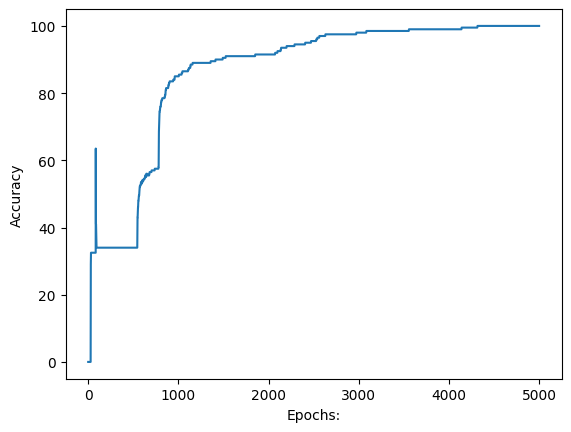

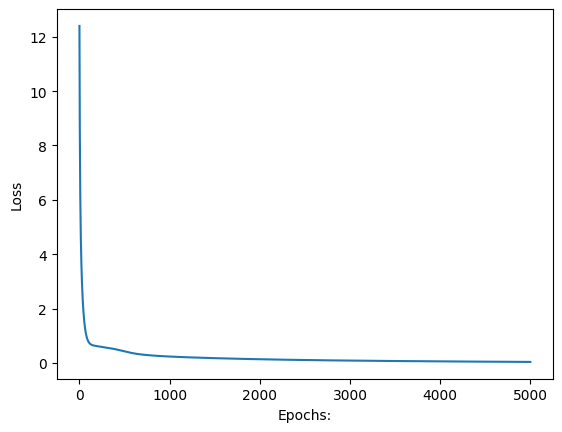

 Loss =  0.42758982933147494  Acc =  54.0
Targets - Predictions - Results
[0] => [0.54340393] => [1.]
[1] => [1.69202227] => [2.]
[2] => [1.30170401] => [1.]
[1] => [1.72022946] => [2.]
[2] => [1.25750361] => [1.]
[1] => [1.81951848] => [2.]
[2] => [0.04784123] => [0.]
[1] => [1.1915901] => [1.]
[0] => [0.04360774] => [0.]
[2] => [0.91305367] => [1.]
[1] => [1.90421827] => [2.]
[2] => [1.35230154] => [1.]
[1] => [1.79659472] => [2.]
[0] => [0.01195039] => [0.]
[0] => [-0.40633129] => [-0.]
[1] => [1.7532972] => [2.]
[1] => [0.50542737] => [1.]
[2] => [1.47484] => [1.]
[2] => [1.82334596] => [2.]
[2] => [1.29754472] => [1.]
[1] => [0.66312542] => [1.]
[0] => [0.42262349] => [0.]
[0] => [0.67611041] => [1.]
[2] => [1.44923911] => [1.]
[1] => [1.74945267] => [2.]
[1] => [0.85199721] => [1.]
[2] => [1.1262619] => [1.]
[1] => [0.22968498] => [0.]
[2] => [1.42065254] => [1.]
[2] => [2.24243874] => [2.]
[1] => [1.30336886] => [1.]
[1] => [1.79108011] => [2.]
[2] => [1.66118043] => [2.]
[2] =>

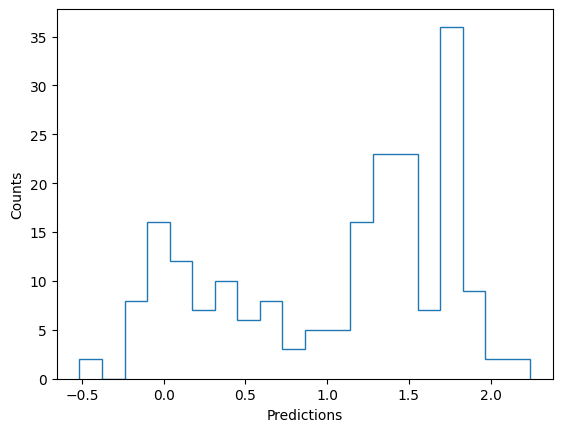

In [10]:
seed_value: bool = False
batch_value: bool = False
batch_num: int = 20
shuffle_value: bool = False

net1 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

train(net1, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

validate(net1, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))

Epoch =  0  Loss =  0.6999198995241711  Acc =  34.0 Pred =  [[0.50039724]
 [0.51498175]
 [0.51498173]
 [0.51498174]
 [0.51498147]
 [0.51498177]
 [0.51496243]
 [0.51498177]
 [0.51498121]
 [0.51498177]
 [0.51498185]
 [0.51498163]
 [0.51497977]
 [0.51498176]
 [0.51498177]
 [0.48991959]
 [0.51498176]
 [0.51498175]
 [0.50918343]
 [0.51254053]
 [0.51498176]
 [0.51497656]
 [0.51498177]
 [0.51498177]
 [0.38967852]
 [0.5114006 ]
 [0.51457797]
 [0.51498177]
 [0.51498177]
 [0.51498177]
 [0.51497796]
 [0.51497177]
 [0.51488294]
 [0.51498174]
 [0.51498176]
 [0.51498177]
 [0.51497512]
 [0.51498175]
 [0.51498177]
 [0.51498127]
 [0.51496303]
 [0.51498376]
 [0.51498177]
 [0.51498176]
 [0.51497885]
 [0.51498177]
 [0.51498156]
 [0.51498175]
 [0.51498177]
 [0.5149797 ]
 [0.51495383]
 [0.51498173]
 [0.51498177]
 [0.51468989]
 [0.51498172]
 [0.51498177]
 [0.51494805]
 [0.51485621]
 [0.51498134]
 [0.51496282]
 [0.51498177]
 [0.5149769 ]
 [0.51498162]
 [0.51497041]
 [0.51492972]
 [0.51497856]
 [0.51498176]
 [

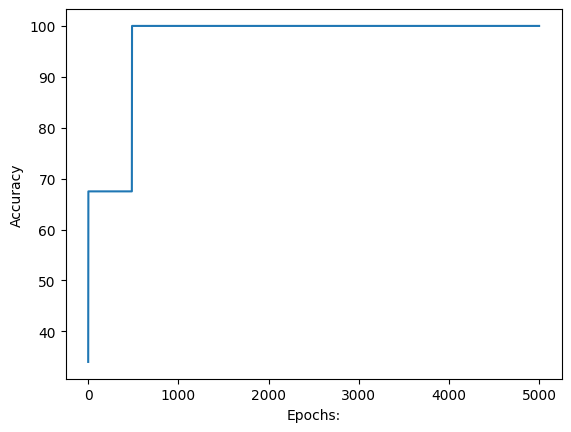

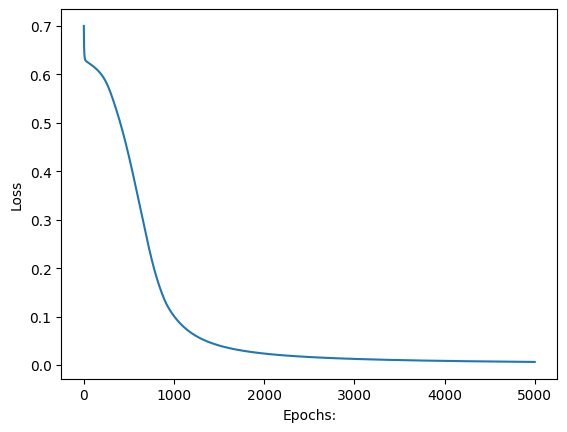

 Loss =  1.3123612985312467  Acc =  67.5
Targets - Predictions - Results
[1] => [0.25611456] => [0.]
[0] => [0.01273476] => [0.]
[0] => [0.00426851] => [0.]
[0] => [0.00424503] => [0.]
[0] => [0.00420584] => [0.]
[0] => [0.00485836] => [0.]
[0] => [0.07227565] => [0.]
[0] => [0.94321358] => [1.]
[1] => [0.99460872] => [1.]
[0] => [0.99468476] => [1.]
[0] => [0.00417814] => [0.]
[0] => [0.00420322] => [0.]
[0] => [0.00427869] => [0.]
[1] => [0.0146851] => [0.]
[1] => [0.99499678] => [1.]
[0] => [0.00424538] => [0.]
[0] => [0.99376021] => [1.]
[0] => [0.00449779] => [0.]
[0] => [0.00423755] => [0.]
[0] => [0.00427114] => [0.]
[0] => [0.99505401] => [1.]
[1] => [0.0673616] => [0.]
[1] => [0.01234523] => [0.]
[0] => [0.00539268] => [0.]
[0] => [0.21094076] => [0.]
[0] => [0.16556738] => [0.]
[0] => [0.05682466] => [0.]
[0] => [0.99430621] => [1.]
[0] => [0.00417986] => [0.]
[0] => [0.0054824] => [0.]
[0] => [0.00427305] => [0.]
[0] => [0.00523642] => [0.]
[0] => [0.03220883] => [0.]
[0] =>

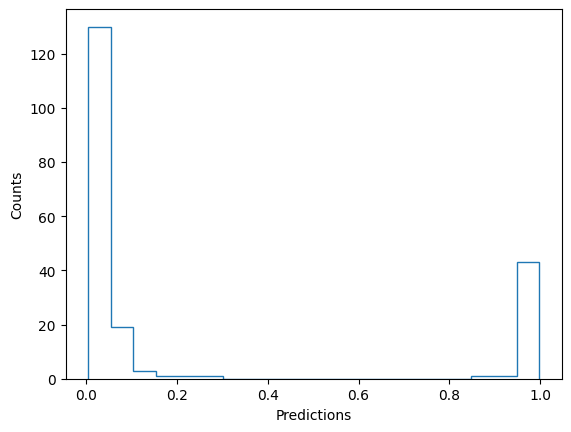

In [11]:
net2 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

train(net2, inputs=dataset1_train.values, targets=bin_labels_train, loss=BinCrossEntropy(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

validate(net2, inputs=dataset1_validation.values, targets=bin_labels_validation, loss=BinCrossEntropy(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))


Epoch =  0  Loss =  0.6905679789365  Acc =  64.33333333333333 Pred =  [[0.62247 0.27652 0.10102]
 [0.54078 0.20392 0.25531]
 [0.16394 0.62498 0.21108]
 [0.54064 0.20644 0.25291]
 [0.07197 0.68028 0.24774]
 [0.54069 0.20618 0.25313]
 [0.15101 0.66228 0.18671]
 [0.54082 0.20276 0.25643]
 [0.54081 0.20304 0.25615]
 [0.54081 0.20296 0.25622]
 [0.1572  0.65553 0.18727]
 [0.05174 0.65857 0.28969]
 [0.54062 0.20819 0.25119]
 [0.5359  0.22422 0.23988]
 [0.54081 0.20321 0.25598]
 [0.41747 0.53937 0.04316]
 [0.54081 0.20308 0.25611]
 [0.54081 0.20273 0.25645]
 [0.15207 0.66021 0.18772]
 [0.57529 0.2926  0.13212]
 [0.5408  0.20346 0.25575]
 [0.54064 0.20961 0.24975]
 [0.54083 0.20234 0.25683]
 [0.54081 0.20299 0.25619]
 [0.4312  0.52731 0.04149]
 [0.38001 0.56503 0.05495]
 [0.15312 0.65696 0.18992]
 [0.54083 0.2023  0.25687]
 [0.14769 0.66578 0.18654]
 [0.54086 0.20092 0.25822]
 [0.54073 0.20663 0.25263]
 [0.44602 0.34264 0.21134]
 [0.54063 0.20998 0.24939]
 [0.5408  0.20334 0.25586]
 [0.54081 0.

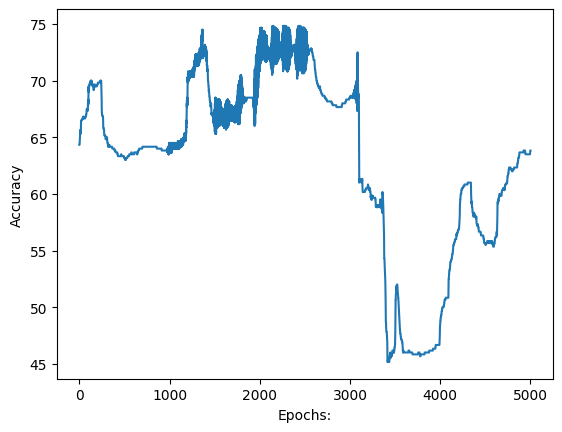

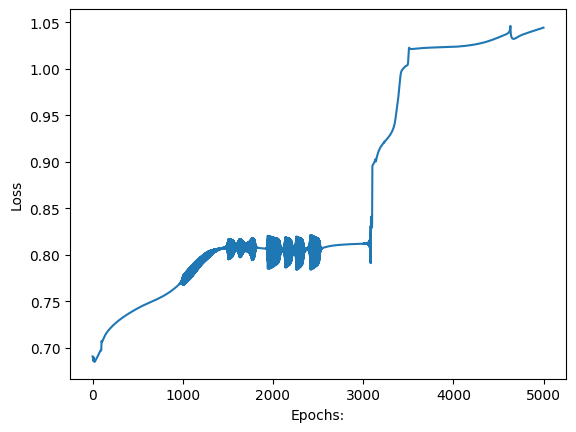

None
 Loss =  0.8475937843225  Acc =  59.333333333333336
Targets - Predictions - Results
[0 0 1] => [0.02505 0.5086  0.46634] => [0. 1. 0.]
[0 1 0] => [0.48302 0.51219 0.00479] => [0. 1. 0.]
[0 1 0] => [0.50486 0.33568 0.15946] => [1. 0. 0.]
[0 1 0] => [0.48125 0.51405 0.0047 ] => [0. 1. 0.]
[0 1 0] => [0.48127 0.51398 0.00475] => [0. 1. 0.]
[0 0 1] => [0.61241 0.35957 0.02801] => [1. 0. 0.]
[0 1 0] => [0.02427 0.49853 0.4772 ] => [0. 0. 0.]
[1 0 0] => [0.03613 0.62198 0.3419 ] => [0. 1. 0.]
[1 0 0] => [0.02466 0.49977 0.47558] => [0. 0. 0.]
[1 0 0] => [0.10592 0.25924 0.63483] => [0. 0. 1.]
[0 0 1] => [0.48479 0.51046 0.00475] => [0. 1. 0.]
[0 1 0] => [0.48115 0.51407 0.00478] => [0. 1. 0.]
[0 0 1] => [0.49175 0.50353 0.00471] => [0. 1. 0.]
[0 1 0] => [0.02433 0.49933 0.47634] => [0. 0. 0.]
[1 0 0] => [0.02456 0.49425 0.4812 ] => [0. 0. 0.]
[0 0 1] => [0.48435 0.5109  0.00475] => [0. 1. 0.]
[1 0 0] => [0.47556 0.5187  0.00574] => [0. 1. 0.]
[1 0 0] => [0.48588 0.50928 0.00484] => [0. 

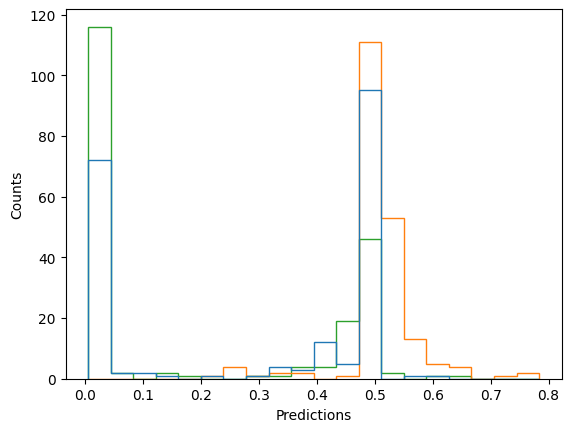

In [16]:
net3 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=3, Seed=seed_value),
    Activation(softmax, softmax_prime),
    #Activation(sigmoid, sigmoid_prime),
])

Pred = train(net3, inputs=dataset1_train.values, targets=cat_labels_train, loss=MeanSquareError(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

print(Pred)

validate(net3, inputs=dataset1_validation.values, targets=cat_labels_train, loss=MeanSquareError(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))
